C:\Users\milan\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\milan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(
C:\Users\milan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\milan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finit

[LightGBM] [Info] Number of positive: 150, number of negative: 62
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.707547 -> initscore=0.883501
[LightGBM] [Info] Start training from score 0.883501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

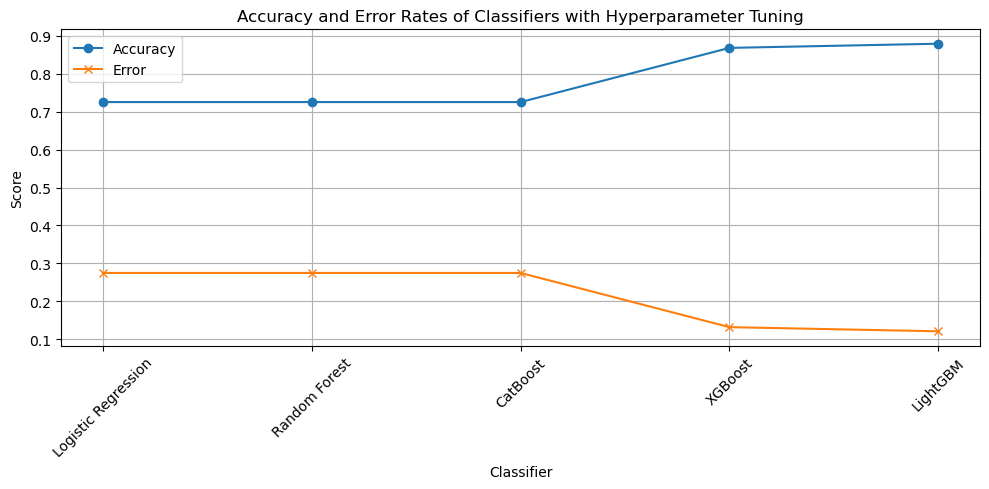


Results Summary:
            Classifier                                        Best Params  \
0             LightGBM                     {'classifier__num_leaves': 10}   
1              XGBoost  {'classifier__max_depth': 1, 'classifier__n_es...   
2  Logistic Regression                           {'classifier__C': 0.001}   
3        Random Forest  {'classifier__max_depth': 1, 'classifier__n_es...   
4             CatBoost  {'classifier__learning_rate': 0.01, 'classifie...   

   Accuracy     Error   ROC-AUC  
0  0.879121  0.120879  0.896364  
1  0.868132  0.131868  0.930303  
2  0.725275  0.274725  0.936970  
3  0.725275  0.274725  0.880000  
4  0.725275  0.274725  0.870000  


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load dataset (replace 'dataset.csv' with the path to your data)
data = pd.read_csv('C:/dataset/CAD.csv')

# Define features and target (Assuming 'Cath' is the target variable)
X = data.drop(columns=['Cath'])
y = data['Cath']

# Identify categorical columns for encoding
categorical_cols = X.select_dtypes(include=['object']).columns  # Columns with text or categorical data

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(exclude=['object']).columns),  # Scale numeric features
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical features
    ])

# Map target variable for binary classification
y = y.map({'Cad': 1, 'Normal': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "CatBoost": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# Define hyperparameter grids for tuning
param_grids = {
    "Logistic Regression": {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    "Random Forest": {'classifier__n_estimators': [10, 50, 100, 200],
                      'classifier__max_depth': list(range(1, 21))},
    "CatBoost": {'classifier__n_estimators': [50, 100, 200],
                          'classifier__learning_rate': [0.01, 0.1, 0.2]},
    "XGBoost": {'classifier__max_depth': list(range(1, 11)),
                'classifier__n_estimators': [50, 100, 200]},
    "LightGBM": {'classifier__num_leaves': [10, 20, 30, 40, 50]}
}

# Initialize lists for plotting conversion graphs
accuracies = []
errors = []

# Initialize a list to store results
results = []

# Loop through classifiers, train and evaluate them
for name, clf in classifiers.items():
    # Create a pipeline that includes preprocessing and the classifier
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    
    # Check if the classifier has hyperparameters to tune
    if name in param_grids:
        # Define Grid Search with cross-validation
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
        
        # Train the model using grid search
        grid_search.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = grid_search.predict(X_test)
        y_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
        
        # Append the best parameters found
        best_params = grid_search.best_params_
    else:
        # Fit the model directly for Naive Bayes
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
        best_params = None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy  # Error as 1 - accuracy
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    # Append results to the list
    results.append({
        'Classifier': name,
        'Best Params': best_params,
        'Accuracy': accuracy,
        'Error': error,
        'ROC-AUC': roc_auc
    })
    
    accuracies.append(accuracy)
    errors.append(error)

# Plot conversion graphs for error minimum and accuracy maximum
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy', marker='o')
plt.plot(errors, label='Error', marker='x')
plt.title('Accuracy and Error Rates of Classifiers with Hyperparameter Tuning')
plt.xlabel('Classifier')
plt.xticks(range(len(classifiers)), list(classifiers.keys()), rotation=45)
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Convert results to DataFrame and sort by accuracy
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Display the results
print("\nResults Summary:")
print(results_df)
